In [53]:
%matplotlib inline
from collections import defaultdict, OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

prefix_dir = '/barleyhome/sgutstei/Projects/opt-tfer-2/results/opt_tfer_expts'
expt_dir = 'tinyimagenet200_notliving_living_expts/wide_resnet_28_10_arch'
src_dir0 = 'mini_src_nets_repeats' #'full_src_nets'
tfer_dir0 = 'tfer_nets_mini_src_nets_repeats/spc_10' #'tfer_nets/spc_10'
spc_dir = 'spc_10'

root_tfer_dir0 = os.path.join(prefix_dir, expt_dir, tfer_dir0)
root_src_dir0 = os.path.join(prefix_dir, expt_dir, src_dir0)

expts_src0 = os.listdir(root_src_dir0)
expts_tfer0 = os.listdir(root_tfer_dir0)

In [54]:
def two_decimal_places(x):
    y = float(int(100 * x))/100.0
    return y

In [55]:
def get_src_stats_dict(root_dir, machine_dirs):
    data_dict = defaultdict(list)
    for curr_mach in machine_dirs:
        curr_file = os.path.join(root_dir, curr_mach,'results.txt')
        with open(curr_file,'r') as f:
            fl = f.readlines()
            data = [x for x in fl if "Epoch" in x]
            for curr_data in data:
                epoch = int(curr_data.split("Epoch")[1].strip().split(":")[0])
                val = float(curr_data.split("val_acc_top_1:")[1].strip().split()[0])*100.0
                data_dict[epoch].append(val)
                
    stat_dict = OrderedDict()
    for x in sorted(data_dict.keys()):
        dd_min = two_decimal_places(np.min(data_dict[x]))
        dd_med = two_decimal_places(np.median(data_dict[x]))
        dd_max = two_decimal_places(np.max(data_dict[x]))
        stat_dict[x] = {'min':dd_min, 'median':dd_med, 'max':dd_max}
    return stat_dict

In [56]:
def get_best_epoch(stats_dict):
    best_epoch = 0
    for curr_epoch in stats_dict:
        if stats_dict[curr_epoch]['median'] > stats_dict[best_epoch]['median']:
            best_epoch = curr_epoch
    return best_epoch


In [57]:
def get_tfer_stats_dict(root_dir, epochs, bes_src_epoch):
    data_dict = defaultdict(list)
    for curr_epoch in epochs:
        curr_epoch_dir = os.path.join(root_dir, curr_epoch)
        curr_key = curr_epoch.split('_')[-1]
        if curr_key == 'best':
            curr_key = best_src_epoch
        else:
            curr_key = int(curr_key)
        machines = os.listdir(curr_epoch_dir)
        for curr_machine in machines:
            curr_machine_dir = os.path.join(curr_epoch_dir, curr_machine)
            tr_sets = os.listdir(curr_machine_dir)
            for curr_tr_set in tr_sets:
                curr_tr_dir = os.path.join(curr_machine_dir, curr_tr_set)
                v_dirs = os.listdir(curr_tr_dir)[0]
                file_dir = os.path.join(curr_tr_dir, v_dirs, 'metadata')
                
                with open(os.path.join(file_dir,'Expt_output.log')) as f:
                    fl = f.readlines()
                    #print (fl[-1].split(":")[-1].split('%')[0].strip())
                    try:
                        acc = float(fl[-1].split(":")[-1].split('%')[0].strip())
                        data_dict[curr_key].append(acc)
                    except:
                        print("Skip ", curr_key, curr_tr_set, file_dir)
                
    stat_dict = OrderedDict()
    full_dict = OrderedDict()
    for x in sorted(data_dict.keys()):
        dd_min = two_decimal_places(np.min(data_dict[x]))
        dd_med = two_decimal_places(np.median(data_dict[x]))
        dd_max = two_decimal_places(np.max(data_dict[x]))
        stat_dict[x] = {'min':dd_min, 'median':dd_med, 'max':dd_max}
        full_dict[x] = sorted(data_dict[x])

    return stat_dict, full_dict

In [99]:
def make_graph(src_net_stats, tfer_net_stats, 
               legend_loc = None, save_name = None):
    
    if legend_loc is None:
        legend_loc = 'lower right'
    
    best_src = get_best_epoch(src_net_stats)
    best_tfer = get_best_epoch(tfer_net_stats)

    fig, ax1 = plt.subplots(1, 1, sharex=True)
    ax2=ax1.twinx()
    src_x = []
    src_y = []
    for k,v in src_net_stats.items():
        src_x.append(k)
        src_y.append(v['median'])
    ax2.plot(src_x, src_y, color='darkgreen', label = "Src Task")

    tfer_x = []
    tfer_min = []
    tfer_med = []
    tfer_max = []
    for k,v in tfer_net_stats.items():
        tfer_x.append(k)
        tfer_min.append(v['min'])
        tfer_med.append(v['median'])
        tfer_max.append(v['max'])

        if k == 0:
            color = 'darkred'
            ax1.plot([0,200],[v['median'],v['median']],
                  color = color, label= "No Tfer")
        elif k == best_src:
            color = 'darkorange'
            ax1.plot([0,200],[v['median'],v['median']],
                  color = color, label= "Best Src Task")
        elif k == best_tfer:
            color = 'darkblue'
            ax1.plot([0,200],[v['median'],v['median']],
                  color = color, label="Best Trgt Task")

        else:
            color = 'dodgerblue'

        ax1.plot([k, k],[v['min'], v['max']],
                  color = color)
        ax1.plot([k],[v['max']],marker='_',
                  color = color)
        ax1.plot([k],[v['median']],marker='8',
                  color = color)
        ax1.plot([k],[v['min']],marker='_',
                  color = color)
        #ax1.set_ylim([0,50])

        ax1.set_xlabel('Source Task Training Epochs', fontsize=12)
        ax1.set_ylabel('Transfer Task Accuracy', fontsize=12)
        ax1.legend(loc=legend_loc, bbox_to_anchor=(0.95,0.15))
        ax2.set_ylabel('Source Task Accuracy', fontsize=12)
        plt.title('Transfer Task Accuracy By Epoch \nWith Src. Task Accuracy and Overtraining')
        
        #ax1.set_xlabel('X axis', fontsize=12)
        #ax1.set_ylabel('Y axis 1', fontsize=12)
        #ax1.legend(loc=legend_loc)#, bbox_to_anchor=(1.6,0.5))
        #ax2.set_ylabel('Y axis 2', fontsize=12)
        #plt.title('Title')
        
        if save_name is not None:
            plt.savefig(save_name)

In [77]:
# Define components of root paths to data
prefix_dir = '/data/other1/data1/Gutstein/results/opt_tfer_expts'
expt_dir = 'tinyimagenet200_notliving_living_expts/wide_resnet_28_10_arch'
src_dir0 = 'full_src_nets'
tfer_dir0 = 'tfer_nets/spc_10'


# Get root paths to data
root_tfer_dir0 = os.path.join(prefix_dir, expt_dir, tfer_dir0)
root_src_dir0 = os.path.join(prefix_dir, expt_dir, src_dir0)

# Get lists of expts
expts_src0 = os.listdir(root_src_dir0)
expts_tfer0 = os.listdir(root_tfer_dir0)

# Get Src and Trgt set data
src_stats_dict = get_src_stats_dict(root_src_dir0, expts_src0)
best_src_epoch = get_best_epoch(src_stats_dict)
tfer_stats_dict, tfer_full_dict = \
                 get_tfer_stats_dict(root_tfer_dir0, expts_tfer0, best_src_epoch)

# Save Src & Trgt Data
pickle.dump([src_stats_dict, tfer_stats_dict],
            open('tinyimagenet200_full_src_trgt_stats_dicts.pkl','wb'))

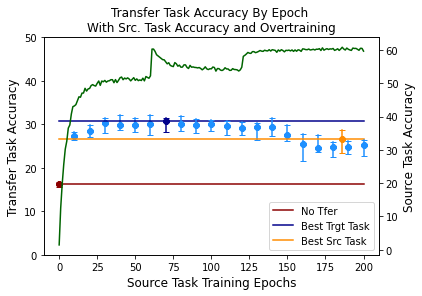

In [78]:
make_graph(src_stats_dict, tfer_stats_dict, 
           save_name= 'TinyImagenet200Full.png')#'WideResnet_TinyImagenet200_FullSrc_Prelim_Results_2.png')

In [80]:
# Define components of root paths to data
prefix_dir = '/data/other1/data1/Gutstein/results/opt_tfer_expts'
expt_dir = 'tinyimagenet200_notliving_living_expts/wide_resnet_28_10_arch'
src_dir0 = 'mini_src_nets/workshop_expts'
tfer_dir0 = 'tfer_nets_mini_src_nets/spc_10'


# Get root paths to data
root_tfer_dir0 = os.path.join(prefix_dir, expt_dir, tfer_dir0)
root_src_dir0 = os.path.join(prefix_dir, expt_dir, src_dir0)

# Get lists of expts
expts_src0 = os.listdir(root_src_dir0)
expts_tfer0 = os.listdir(root_tfer_dir0)

# Get Src and Trgt set data
src_stats_dict = get_src_stats_dict(root_src_dir0, expts_src0)
best_src_epoch = get_best_epoch(src_stats_dict)
tfer_stats_dict, tfer_full_dict = \
                 get_tfer_stats_dict(root_tfer_dir0, expts_tfer0, best_src_epoch)

# Save Src & Trgt Data
pickle.dump([src_stats_dict, tfer_stats_dict],
            open('tinyimagenet200_mini_src_trgt_stats_dicts.pkl','wb'))

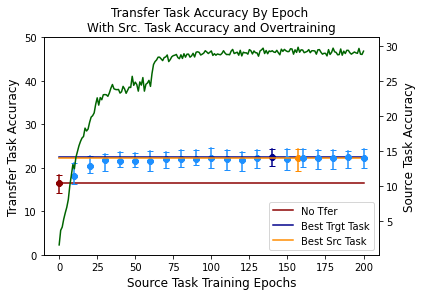

In [81]:
make_graph(src_stats_dict, tfer_stats_dict, 
           save_name= 'TinyImagenet200Mini.png')

In [85]:
# Define components of root paths to data
prefix_dir = '/data/other1/data1/Gutstein/results/opt_tfer_expts'
expt_dir = 'caltech101_living_notliving_expts/wide_resnet_28_10_arch'
src_dir0 = 'src_nets/workshop_expts'
tfer_dir0 = 'tfer_nets/spc_10'


# Get root paths to data
root_tfer_dir0 = os.path.join(prefix_dir, expt_dir, tfer_dir0)
root_src_dir0 = os.path.join(prefix_dir, expt_dir, src_dir0)

# Get lists of expts
expts_src0 = os.listdir(root_src_dir0)
expts_tfer0 = os.listdir(root_tfer_dir0)

# Get Src and Trgt set data
src_stats_dict = get_src_stats_dict(root_src_dir0, expts_src0)
best_src_epoch = get_best_epoch(src_stats_dict)
tfer_stats_dict, tfer_full_dict = \
                 get_tfer_stats_dict(root_tfer_dir0, expts_tfer0, best_src_epoch)

# Save Src & Trgt Data
pickle.dump([src_stats_dict, tfer_stats_dict],
            open('caltech101_src_trgt_stats_dicts.pkl','wb'))

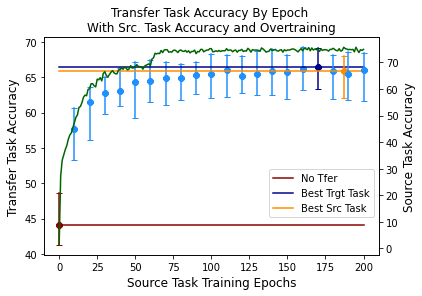

In [94]:
make_graph(src_stats_dict, tfer_stats_dict, 
           save_name= 'Caltech101.png')

In [12]:
src_stats_dict2, tfer_stats_dict2 = pickle.load(open('src_trgt_stats_dicts.pkl','rb'))

In [95]:
# Define components of root paths to data
prefix_dir = '/data/other1/data1/Gutstein/results/opt_tfer_expts'
expt_dir = 'cifar_100_living_notliving_expts/wide_resnet_28_10_arch'
src_dir0 = 'src_nets/workshop_expts'
tfer_dir0 = 'tfer_nets/spc_10'


# Get root paths to data
root_tfer_dir0 = os.path.join(prefix_dir, expt_dir, tfer_dir0)
root_src_dir0 = os.path.join(prefix_dir, expt_dir, src_dir0)

# Get lists of expts
expts_src0 = os.listdir(root_src_dir0)
expts_tfer0 = os.listdir(root_tfer_dir0)

# Get Src and Trgt set data
src_stats_dict = get_src_stats_dict(root_src_dir0, expts_src0)
best_src_epoch = get_best_epoch(src_stats_dict)
tfer_stats_dict, tfer_full_dict = \
                 get_tfer_stats_dict(root_tfer_dir0, expts_tfer0, best_src_epoch)

# Save Src & Trgt Data
pickle.dump([src_stats_dict, tfer_stats_dict],
            open('cifar100_src_trgt_stats_dicts.pkl','wb'))

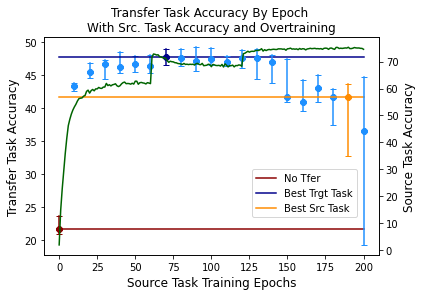

In [100]:
make_graph(src_stats_dict, tfer_stats_dict, 
           save_name= 'Cifar100.png')

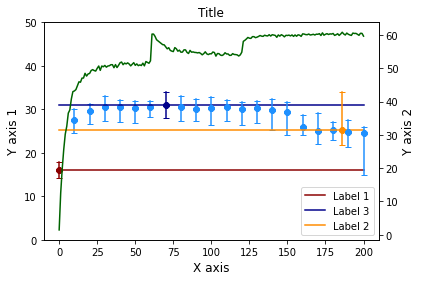

In [13]:
make_graph(src_stats_dict2, tfer_stats_dict2, save_name= 'Temp2.png')#'WideResnet_TinyImagenet200_FullSrc_Prelim_Results_2.png')